In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#import the mnist dataset
from tensorflow.keras.datasets import mnist

In [3]:
(X_train,y_train),(X_test,y_test) =  mnist.load_data()

In [4]:
X_train.shape

(60000, 28, 28)

In [5]:
X_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

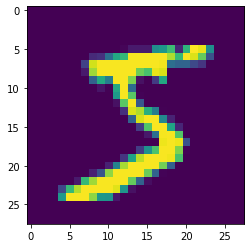

In [6]:
plt.imshow(X_train[0])

In [7]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [8]:
#selecting only zeros from the mnist dataset so that its easier to generate the number

In [9]:
y_train == 0

array([False,  True, False, ..., False, False, False])

In [10]:
only_zeros = X_train[y_train == 0 ]

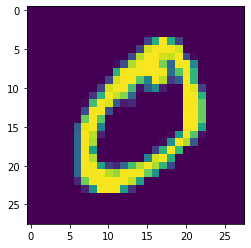

In [11]:
plt.imshow(only_zeros[0])

In [12]:
only_zeros.shape

(5923, 28, 28)

In [13]:
#building the 2 models for the GAN ie Discriminator and Generator

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Reshape
import tensorflow as tf

In [15]:
# Discriminator model
discriminator = Sequential()

In [16]:
discriminator.add(Flatten(input_shape=[28,28]))
discriminator.add(Dense(150,activation='relu'))
discriminator.add(Dense(100,activation='relu'))
discriminator.add(Dense(1,activation='sigmoid'))

#compile the model with loss='binary crossentropy as it is basically checking whether the image generated is real(1) or fake(0) '
discriminator.compile(loss='binary_crossentropy',optimizer='adam')

In [17]:
#generator model
generator = Sequential()

In [18]:
np.random.seed(42)
tf.random.set_seed(42)

In [19]:
#generator is basically a decoder which tries to generate the image
coding_size = 100

In [20]:
generator.add(Dense(100,input_shape=[coding_size],activation='relu'))
generator.add(Dense(150,activation='relu'))
generator.add(Dense(784,activation='sigmoid'))
#the image has been decoded (28*28=784)
generator.add(Reshape((28,28)))

In [21]:
#combine both the models to form the GAN

In [22]:
GAN = Sequential([generator,discriminator])

In [23]:
#the discriminator should not undergo backpropagation while training the GAN model
discriminator.trainable = False

In [24]:
GAN.compile(loss='binary_crossentropy',optimizer='adam')

In [25]:
GAN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 28, 28)            143634    
_________________________________________________________________
sequential (Sequential)      (None, 1)                 132951    
Total params: 276,585
Trainable params: 143,634
Non-trainable params: 132,951
_________________________________________________________________


In [26]:
GAN.layers

In [27]:
#the generator model
GAN.layers[0].summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 150)               15150     
_________________________________________________________________
dense_5 (Dense)              (None, 784)               118384    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 143,634
Trainable params: 143,634
Non-trainable params: 0
_________________________________________________________________


In [28]:
# discriminator model
GAN.layers[1].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 150)               117750    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               15100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 265,902
Trainable params: 132,951
Non-trainable params: 132,951
_________________________________________________________________


In [29]:
#using tensorflows tensor slices create the batches to train on

In [30]:
batch_size = 32

In [31]:
my_data = only_zeros

In [32]:
#set the shuffle method with buffer size=1000 so that it shuffles 1000 images at a time
dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)

In [33]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.ShuffleDataset

In [34]:
len(my_data)/batch_size

185.09375

In [35]:
#set drop remainder= true so that the batches are perfectly set to 185

In [36]:
dataset = dataset.batch(batch_size,drop_remainder=True)

In [37]:
dataset

<BatchDataset shapes: (32, 28, 28), types: tf.uint8>

In [38]:
#create the training loop to train the discriminant first and then the generator

In [39]:
#The generator never actually sees any real images.
#It learns by viewing the gradients going back through the discriminator. 
#The better the discrimnator gets through training, the more information the discriminator contains in its gradients, which means the generator can being to make progress in learning how to generate fake images, in our case, fake zeros.

In [40]:
generator,discriminator = GAN.layers

In [41]:
epochs= 1

In [42]:
#set the labels for the discrimanator where the gen_image is 0 and real images is 1 for batch size=32
[[0.]] * batch_size + [[1.]] * batch_size

[[0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0]]

In [43]:
for epoch in range(epochs):
    print(f"currently on epoch:{epoch+1}")
    i = 0
    for X_batch in dataset:
        i=i+1
        if i%10 == 0:
            print(f"\tCurrently on batch number {i} of {len(my_data)//batch_size}")
        #####################################
        ## TRAINING THE DISCRIMINATOR ######
        ###################################
        
        # Create Noise
        noise = tf.random.normal(shape=[batch_size, coding_size])
        
        # Generate numbers based just on noise input
        gen_images = generator(noise)
        
        # Concatenate Generated Images against the Real Ones
        # TO use tf.concat, the data types must match!
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch,tf.float32)], axis=0)
        
        # Targets set to zero for fake images and 1 for real images
        y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
        
        # This gets rid of a Keras warning
        discriminator.trainable = True
        
        # Train the discriminator on this batch
        discriminator.train_on_batch(X_fake_vs_real, y1)
        
        
        #####################################
        ## TRAINING THE GENERATOR     ######
        ###################################
        
        # Create some noise
        noise = tf.random.normal(shape=[batch_size, coding_size])
        
        # We want discriminator to belive that fake images are real
        y2 = tf.constant([[1.]] * batch_size)
        
        # Avois a warning
        discriminator.trainable = False
        
        GAN.train_on_batch(noise, y2)
        
print("TRAINING COMPLETE")

currently on epoch:1
	Currently on batch number 10 of 185
	Currently on batch number 20 of 185
	Currently on batch number 30 of 185
	Currently on batch number 40 of 185
	Currently on batch number 50 of 185
	Currently on batch number 60 of 185
	Currently on batch number 70 of 185
	Currently on batch number 80 of 185
	Currently on batch number 90 of 185
	Currently on batch number 100 of 185
	Currently on batch number 110 of 185
	Currently on batch number 120 of 185
	Currently on batch number 130 of 185
	Currently on batch number 140 of 185
	Currently on batch number 150 of 185
	Currently on batch number 160 of 185
	Currently on batch number 170 of 185
	Currently on batch number 180 of 185
TRAINING COMPLETE


In [44]:
#lets generate some new zeros

In [45]:
#first create some noise to start of with

In [46]:
noise = tf.random.normal(shape=[10,coding_size])

In [47]:
#should be the same shape of generator (none,100)
noise.shape

TensorShape([10, 100])

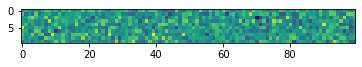

In [48]:
plt.imshow(noise)

In [49]:
new_img = generator(noise)

In [50]:
new_img

<tf.Tensor: id=73565, shape=(10, 28, 28), dtype=float32, numpy=
array([[[8.48770142e-05, 2.06232071e-05, 8.51750374e-05, ...,
         1.06394291e-05, 4.26769257e-05, 2.77936459e-04],
        [3.65972519e-05, 1.17033720e-04, 1.50799751e-05, ...,
         3.51965427e-05, 2.63601542e-04, 1.93119049e-05],
        [9.32812691e-06, 3.17394733e-05, 3.12924385e-05, ...,
         1.11758709e-05, 2.07394361e-04, 3.55243683e-05],
        ...,
        [2.51233578e-05, 3.27825546e-05, 2.05039978e-05, ...,
         2.27689743e-05, 1.78754330e-04, 7.30752945e-05],
        [4.06205654e-05, 2.04443932e-05, 2.41696835e-05, ...,
         1.20103359e-05, 4.61935997e-06, 1.70469284e-05],
        [5.30481339e-06, 7.94529915e-05, 1.46806240e-04, ...,
         4.54485416e-05, 5.87701797e-05, 6.97076321e-05]],

       [[1.31428242e-05, 2.26497650e-06, 1.29938126e-05, ...,
         7.45058060e-07, 9.71555710e-06, 2.22325325e-05],
        [4.02331352e-06, 1.44839287e-05, 1.84774399e-06, ...,
         3.12924385

In [51]:
#the generator has generated 10 new images

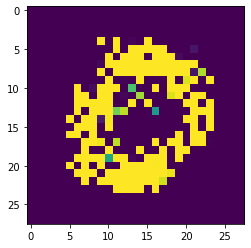

In [52]:
plt.imshow(new_img[0])

In [54]:
GAN.save('ps_gan.h5')

In [53]:
#the gan has produced a somewhat circular image!